## 1. Data Processing
- Data loading and preprocessing (e.g., normalization, resizing, augmentation).
- Create visualizations of some images, and labels.

In [2]:
# Importing libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [3]:
#Unpickle the data files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
#Standard Deviation Calculation: Calculate the standard deviation value for each channel across all training images

import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Define the transform with normalization
transform_with_normalization = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and standard deviation
])

# Load the CIFAR-10 training dataset with normalization
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_with_normalization)

# Initialize tensors to store channel-wise mean and standard deviation
mean = torch.zeros(3)
std = torch.zeros(3)

# Calculate mean and standard deviation for each channel
for images, _ in train_dataset:
    # Flatten the image tensor for each channel and calculate mean and standard deviation
    for i in range(3):  # Iterate over RGB channels
        mean[i] += torch.mean(images[i])
        std[i] += torch.std(images[i])

# Calculate the mean and standard deviation for the entire dataset
mean /= len(train_dataset)
std /= len(train_dataset)

# Calculate the final outcome
print("Mean:", mean.tolist())
print("Standard Deviation:", std.tolist())

Files already downloaded and verified
Mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
Standard Deviation: [tensor(0.2023), tensor(0.1994), tensor(0.2010)]


In [5]:
#Load the dataset

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Pre-calculated mean and standard deviation values
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Define transformations for training and testing sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


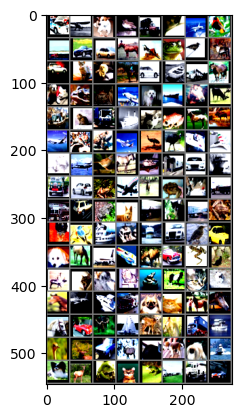

automobile airplane   dog  bird


In [6]:
#Visualization

import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Function to show an image
def imshow(img, mean=0.5, std=0.5):
    img = img * std + mean  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Example usage:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use the next function

# Show images
imshow(torchvision.utils.make_grid(images), mean=0.5, std=0.5)

# Print labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Model Architecture
- Design a CNN suitable for CIFAR-10 classification.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the feature maps
        x = x.view(-1, 128 * 4 * 4)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the network
net = Net()

### 3. Model Training
- Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
- Utilize techniques such as early stopping to prevent overfitting.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models, transforms
from tqdm import tqdm
from tabulate import tabulate

# Function to calculate accuracy
def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Check available device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_info = "GPU acceleration in place powered by nVIDIA (CUDA)"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_info = "GPU acceleration in place powered by Apple's Metal Performance Shaders (MPS)"
else:
    device = torch.device("cpu")
    device_info = "Using CPU... Best of luck..."

print("Training the Model")
print(device_info)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

# Load a pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)  # Adapt to CIFAR-10 classes
resnet = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Training loop with tqdm progress bar
num_epochs = 10
training_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    trainloader_with_progress = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)

    for i, data in enumerate(trainloader_with_progress, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        trainloader_with_progress.set_postfix(loss=running_loss / (i + 1))

    # Store training loss
    training_loss = running_loss / len(trainloader)
    training_losses.append(training_loss)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(valloader, resnet, device)
    validation_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.4f}")

print('Finished Training')

# Prepare data for tabulate
table_data = [
    ["Device", device_info],
    ["Training Loss (Avg)", sum(training_losses) / len(training_losses)],
    ["Validation Accuracy (Last Epoch)", validation_accuracies[-1]]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="pretty"))


Training the Model
Powered by Apple's Metal Performance Shaders (MPS)
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10: 100%|██████████| 1563/1563 [10:12<00:00,  2.55it/s, loss=0.677]


Epoch 1 Validation Accuracy: 0.8397


Epoch 2/10: 100%|██████████| 1563/1563 [10:10<00:00,  2.56it/s, loss=0.4]  


Epoch 2 Validation Accuracy: 0.8640


Epoch 3/10: 100%|██████████| 1563/1563 [10:09<00:00,  2.56it/s, loss=0.291]


Epoch 3 Validation Accuracy: 0.8857


Epoch 4/10: 100%|██████████| 1563/1563 [10:11<00:00,  2.56it/s, loss=0.21] 


Epoch 4 Validation Accuracy: 0.8916


Epoch 5/10: 100%|██████████| 1563/1563 [10:11<00:00,  2.56it/s, loss=0.158]


Epoch 5 Validation Accuracy: 0.8907


Epoch 6/10: 100%|██████████| 1563/1563 [10:06<00:00,  2.58it/s, loss=0.118]


Epoch 6 Validation Accuracy: 0.8896


Epoch 7/10: 100%|██████████| 1563/1563 [13:45<00:00,  1.89it/s, loss=0.1]     


Epoch 7 Validation Accuracy: 0.8893


Epoch 8/10: 100%|██████████| 1563/1563 [45:39<00:00,  1.75s/it, loss=0.0827]   


Epoch 8 Validation Accuracy: 0.9001


Epoch 9/10: 100%|██████████| 1563/1563 [10:05<00:00,  2.58it/s, loss=0.0731]


Epoch 9 Validation Accuracy: 0.8954


Epoch 10/10: 100%|██████████| 1563/1563 [10:12<00:00,  2.55it/s, loss=0.0628]


Epoch 10 Validation Accuracy: 0.8931
Finished Training
+----------------------------------+----------------------------------------------------+
|              Metric              |                       Value                        |
+----------------------------------+----------------------------------------------------+
|              Device              | Powered by Apple's Metal Performance Shaders (MPS) |
|       Training Loss (Avg)        |                0.21736265760443024                 |
| Validation Accuracy (Last Epoch) |                       0.8931                       |
+----------------------------------+----------------------------------------------------+


### 4. Model Evaluation
- Evaluate the trained model on the test set.
- Compute metrics: accuracy, precision, recall, F1-score.
- Visualize the confusion matrix.

Evaluation Progress: 100%|██████████| 79/79 [00:05<00:00, 15.72it/s]

+-----------+---------------------+
|  Metric   |        Value        |
+-----------+---------------------+
| Accuracy  |        0.111        |
| Precision | 0.07357271894546709 |
|  Recall   | 0.11099999999999999 |
| F1 Score  | 0.04617261381336486 |
+-----------+---------------------+



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


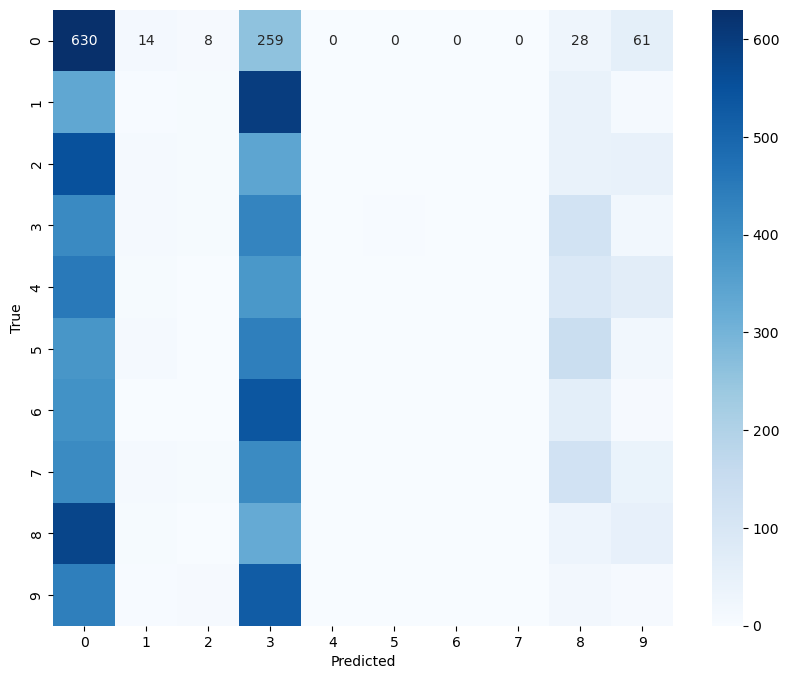

In [23]:
# Evaluate on test data
net.eval()  # Set the model to evaluation mode

y_true = []
y_pred = []

# Initialize tqdm progress bar
progress_bar = tqdm(testloader, desc='Evaluation Progress', dynamic_ncols=True)

with torch.no_grad():
    for data in progress_bar:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division='warn')
recall = recall_score(y_true, y_pred, average='macro', zero_division='warn')
f1 = f1_score(y_true, y_pred, average='macro', zero_division='warn')

# Prepare data for tabulate
table = [
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1]
]

# Print the table
print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 5. Transfer Learning
- Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
- Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

In [49]:
# Importing essential libraries
# Standard Library Imports
import os
import warnings

# Third-Party Library Imports
import numpy as np
import tensorflow as tf
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections.abc import Iterator


# TensorFlow and Keras Imports
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [51]:
# Load the data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Prepare the data for tabulate
from tabulate import tabulate

table = [
    ["Training Data", x_train.shape, y_train.shape],
    ["Testing Data", x_test.shape, y_test.shape]
]

# Print the table
print(tabulate(table, headers=["Dataset", "X Shape", "Y Shape"], tablefmt="pretty"))

+---------------+-----------------+----------+
|    Dataset    |     X Shape     | Y Shape  |
+---------------+-----------------+----------+
| Training Data | (60000, 28, 28) | (60000,) |
| Testing Data  | (10000, 28, 28) | (10000,) |
+---------------+-----------------+----------+


In [53]:
# Change the type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Convert data to 3 channels
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Prepare the data for tabulate
table = [
    ["Training Data", x_train.shape, y_train.shape],
    ["Validation Data", x_val.shape, y_val.shape],
    ["Testing Data", x_test.shape, y_test.shape]
]

# Print the table
print(tabulate(table, headers=["Dataset", "X Shape", "Y Shape"], tablefmt="pretty"))


+-----------------+--------------------+-------------+
|     Dataset     |      X Shape       |   Y Shape   |
+-----------------+--------------------+-------------+
|  Training Data  | (48000, 28, 28, 3) | (48000, 10) |
| Validation Data | (12000, 28, 28, 3) | (12000, 10) |
|  Testing Data   | (10000, 28, 28, 3) | (10000, 10) |
+-----------------+--------------------+-------------+


In [55]:
# Suppress all logs except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Define image data generators
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)

# Reshape input data to have rank 4
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Create iterators
train_iterator = train_generator.flow(x_train, y_train, batch_size=512, shuffle=True)
val_iterator = val_generator.flow(x_val, y_val, batch_size=512, shuffle=False)

# Define the batch size
batch_size = 512

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (144000, 28, 28, 1), y.shape = (48000, 10)

In [37]:
# Using ImagNET model ResNet50
# Suppress all logs except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Create the model
model = Sequential()

# Add the pretrained ResNet50 model
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

# Add fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Freeze ResNet layers
model.layers[0].trainable = False

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os
from tabulate import tabulate

# Suppress all logs except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check available device (GPU, MPS, CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else ("APPLE MPS" if torch.backends.mps.is_available() else "cpu"))
print(f"Training model using ResNet18 powered by {device} acceleration")

# Load pre-trained ResNet18 model
resnet = models.resnet18(pretrained=True)

# Modify last layer for CIFAR-10 (10 classes)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

# Transfer learning training
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Training loop for transfer learning
num_epochs = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit=" batch")
    for i, data in progress_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        if i % 200 == 199:
            progress_bar.set_postfix({'loss': running_loss / 200})
            running_loss = 0.0

    # Calculate training accuracy and loss
    train_loss = running_loss / len(trainloader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(valloader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

print('Finished Transfer Learning Training')

# Display statistics in a table
table_data = [
    ["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc"],
]
for i in range(num_epochs):
    table_data.append([i+1, train_losses[i], train_accs[i], val_losses[i], val_accs[i]])

print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))

In [ ]:
# Using VGG16 for training
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# Add the pretrained VGG16 model.
model.add(VGG16(include_top = False, pooling = 'avg', weights = 'imagenet'))
# Add fully connected layer with output.
model.add(Dense(512, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

# Freeze VGG16 layers.
model.layers[0].trainable = False
model.summary()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

# Check if GPU or MPS (Apple Silicon) is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Running VGG16 powered by: {device}")

# Load a pre-trained ResNet model
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the last layer for CIFAR-10 (10 classes)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

# Transfer learning training
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Training loop for transfer learning
for epoch in range(10):
    running_loss = 0.0
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/10", unit="batch")
    for i, data in progress_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            progress_bar.set_postfix({'loss': running_loss / 200})
            running_loss = 0.0

print('Finished Transfer Learning Training')

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs except errors

model = Sequential()

# Add the pretrained InceptionV3 model.
model.add(InceptionV3(include_top=False, pooling='avg', weights='imagenet'))

# Add fully connected layer with output.
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Freeze InceptionV3 layers.
model.layers[0].trainable = False

model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import torch
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs except errors

# Check if GPU or MPS (Apple Silicon) is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Running InceptionV3 powered by {device}")

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define a function to perform data augmentation
def augment_images(images):
    augmented_images = tf.image.random_flip_left_right(images)
    augmented_images = tf.image.random_flip_up_down(augmented_images)
    augmented_images = tf.image.random_contrast(augmented_images, lower=0.9, upper=1.1)
    augmented_images = tf.image.random_brightness(augmented_images, max_delta=0.1)
    return augmented_images

# Define a function to resize images
def resize_images(images):
    return tf.image.resize(images, (224, 224))

# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classifier layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Combine the base model with custom classifier layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam()

# Use mixed precision training
if device == "cuda:0":
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    # Perform data augmentation on-the-fly
    augmented_x_train = augment_images(x_train)
    resized_x_train = resize_images(augmented_x_train)

    # Train the model
    model.fit(resized_x_train, y_train, validation_data=(x_test, y_test), epochs=1, verbose=1)

    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'Test Accuracy: {test_acc:.4f}')

In [ ]:
# Save the final model (optional)
#torch.save(model.state_dict(), 'VGG16_model.pth')
#print('Model saved to VGG16_model.pth')

### 8.Model deployment
- Pick the best model
- Build an app using Flask - Can you host somewhere other than your laptop? +5 Bonus points if you use Tensorflow Serving
- User should be able to upload one or multiples images get predictions including probabilities for each prediction

#### Step 1: Train and Save the Best Model
- First, ensure you have a trained VGG16 model saved in a format suitable for TensorFlow Serving. Here’s an example of how to save the model:First, ensure you have a trained VGG16 model saved in a format suitable for TensorFlow Serving. Here’s an example of how to save the model:

`import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical`

`# Load CIFAR-10 dataset`
`(x_train, y_train), (x_test, y_test) = cifar10.load_data()`

`# Normalize the data`
`x_train = x_train.astype('float32') / 255.0`
`x_test = x_test.astype('float32') / 255.0`


`# One-hot encode the labels`
`y_train = to_categorical(y_train, 10)`
`y_test = to_categorical(y_test, 10)`

`# Load the VGG16 model without the top layer`
`base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))`

`# Freeze base model layers for fine-tuning`
`base_model.trainable = False`

`# Add custom top layers`
`x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)`  `# CIFAR-10 has 10 classes`

`# Create the model`
`model = Model(inputs=base_model.input, outputs=predictions)`

`# Compile the model with a lower learning rate for fine-tuning`
`model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])`

`# Train the model for a few epochs`
`model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))`

`# Save the model in a format suitable for TensorFlow Serving`
`tf.saved_model.save(model, "path_to_saved_model")`
`

#### Step 2: Set Up TensorFlow Serving
Install TensorFlow Serving and run it to serve your model.

##### Install TensorFlow Serving:

On Debian-based systems
`echo "deb [trusted=yes] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && sudo apt update && sudo apt install tensorflow-model-server`

Start TensorFlow Serving:
`tensorflow_model_server --rest_api_port=8501 --model_name=my_model --model_base_path="path_to_saved_model"`

#### Step 3: Build a Flask Application
Create a Flask application to handle image uploads and make predictions using the served model.

In [ ]:
#Install Flask:
!pip install flask

#Create the Flask App (app.py):
import os
import requests
from flask import Flask, request, jsonify
from werkzeug.utils import secure_filename
import numpy as np
from PIL import Image

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads'

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def preprocess_image(image_path):
    image = Image.open(image_path).resize((32, 32))
    image = np.array(image).astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'})
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'})
    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)
        
        # Preprocess the image
        image = preprocess_image(file_path)
        
        # Make a prediction
        url = 'http://localhost:8501/v1/models/my_model:predict'
        data = json.dumps({"instances": image.tolist()})
        headers = {"content-type": "application/json"}
        json_response = requests.post(url, data=data, headers=headers)
        predictions = json_response.json()['predictions'][0]
        
        # Return the predictions with probabilities
        return jsonify({'predictions': predictions})
    else:
        return jsonify({'error': 'File type not allowed'})

if __name__ == '__main__':
    if not os.path.exists(app.config['UPLOAD_FOLDER']):
        os.makedirs(app.config['UPLOAD_FOLDER'])
    app.run(host='0.0.0.0', port=5000)

#### Step 4: Run the Flask Application
Start your Flask application:

bash
`!python app.py`

#### Step 5: Upload Images and Get Predictions
You can use a tool like Postman or cURL to send an image to the Flask app and get predictions.

Example cURL Command:
`curl -X POST -F 'file=@path_to_image.jpg' http://localhost:5000/predict`

### This setup ensures your VGG16 model is served using TensorFlow Serving, and a Flask application allows users to upload images and receive predictions with probabilities.

# Tests and stuff

In [ ]:
# 5. Transfer learning


# Check if GPU or MPS (Apple Silicon) is available and set device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU: cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS: mps")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Load a pre-trained ResNet model
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the last layer for CIFAR-10 (10 classes)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

# Transfer learning training
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Training loop for transfer learning
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Transfer Learning Training')


In [ ]:
#Model Deployment
#Deploy the best model using Flask and TensorFlow Serving. Create an app allowing users to upload images and get predictions.
#Flask App Example:
